# **Parcial 1 Inteligencia Artificial**

## Punto 1.
### Visualización del Modelo de Detección de VPN como un Grafo Dirigido

En esta sección, se presenta una visualización del modelo de clasificación de usuarios que hemos diseñado. El problema se ha modelado como un grafo dirigido, donde los nodos representan los estados de una sesión de usuario y las aristas son las transiciones entre estos estados, impulsadas por las acciones del usuario.

Este grafo nos permite entender de manera clara los flujos de comportamiento que nuestra IA debe aprender a distinguir.

* **Nodos (Estados):** Representan el estado actual del usuario en la plataforma. Por ejemplo, si se está verificando su autenticación o si se ha detectado una discrepancia geográfica.
* **Aristas (Transiciones):** Simbolizan los eventos que hacen que el estado del usuario cambie. Por ejemplo, una arista etiquetada como `auth_check` indica que el sistema está validando las credenciales.
* **Caminos:** El grafo ilustra los diferentes caminos que una sesión puede seguir, desde el inicio (`q0`) hasta la clasificación final como usuario legítimo o pirata.

**La lógica clave del modelo es la siguiente:**

1.  **Camino Legítimo:** El usuario se autentica correctamente y su geolocalización coincide. Al intentar ver un video, se le clasifica como usuario legal.
2.  **Camino de Alerta (VPN):** Un usuario se autentica pero el sistema detecta una discrepancia de IP (VPN).
3.  **Camino Pirata:** El usuario, en el estado de alerta por VPN, intenta acceder a contenido. Esta combinación de eventos es la señal que nuestra IA usará para clasificarlo como pirata.
4.  **Camino de Falso Positivo:** Si un usuario con una VPN finaliza la sesión sin intentar acceder a contenido, no hay suficiente evidencia para clasificarlo como pirata.

#


📌 Significado de los estados:
  q0 → Inicio
  q1 → Auth Check
  q2 → Geo Match
  q3 → Auth Invalid
  q4 → Geo Mismatch
  q5 → Stream Attempt
  q6 → Usuario Legal
  q7 → Usuario Pirata


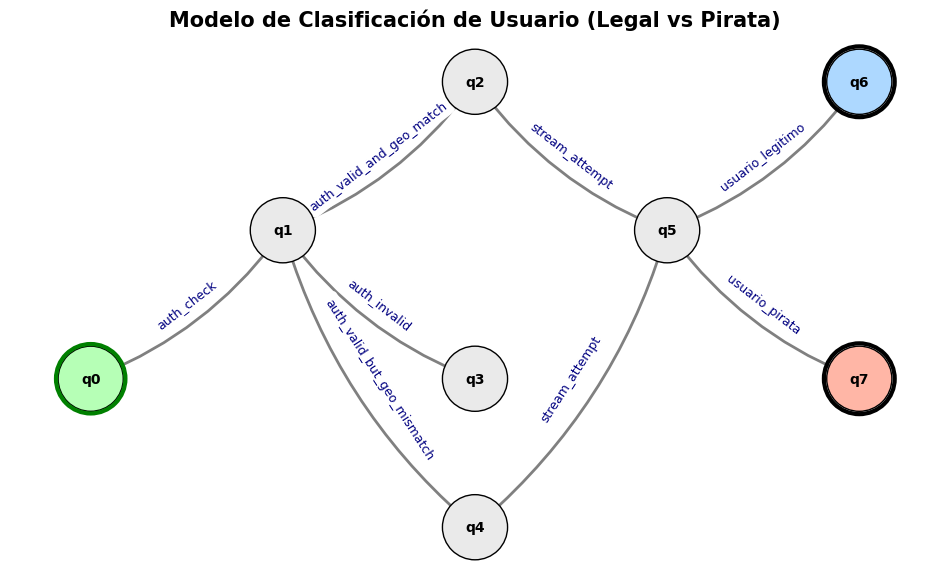

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Definición del grafo con transiciones
G = nx.DiGraph()
edges = [
    ('q0', 'q1', 'auth_check'),
    ('q1', 'q2', 'auth_valid_and_geo_match'),
    ('q1', 'q3', 'auth_invalid'),
    ('q1', 'q4', 'auth_valid_but_geo_mismatch'),
    ('q2', 'q5', 'stream_attempt'),
    ('q4', 'q5', 'stream_attempt'),
    ('q5', 'q6', 'usuario_legitimo'),
    ('q5', 'q7', 'usuario_pirata')
]
G.add_weighted_edges_from([(u, v, 1) for u, v, _ in edges], weight="label")

# Diccionario de equivalencias
state_meanings = {
    'q0': 'Inicio',
    'q1': 'Auth Check',
    'q2': 'Geo Match',
    'q3': 'Auth Invalid',
    'q4': 'Geo Mismatch',
    'q5': 'Stream Attempt',
    'q6': 'Usuario Legal',
    'q7': 'Usuario Pirata'
}

# Imprimir significado de cada estado
print("\n📌 Significado de los estados:")
for q, meaning in state_meanings.items():
    print(f"  {q} → {meaning}")

# Posiciones de los nodos
pos = {
    'q0': (0, 0),
    'q1': (2, 1),
    'q2': (4, 2),
    'q3': (4, 0),
    'q4': (4, -1),
    'q5': (6, 1),
    'q6': (8, 2),
    'q7': (8, 0)
}

# Dibujar grafo
plt.figure(figsize=(12, 7), facecolor="white")

nx.draw_networkx_edges(
    G, pos,
    edge_color="gray", arrows=True, arrowsize=20, width=2,
    connectionstyle="arc3,rad=0.15"
)

# Colores personalizados
node_colors = []
for node in G.nodes():
    if node == 'q0':
        node_colors.append('#B6FFB6')  # Inicio
    elif node == 'q6':
        node_colors.append('#ADD8FF')  # Legal
    elif node == 'q7':
        node_colors.append('#FFB6A6')  # Pirata
    else:
        node_colors.append('#EAEAEA')  # Intermedios

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2200, edgecolors="black")

# Etiquetas de nodos (solo los nombres técnicos q0, q1, etc.)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Etiquetas de aristas
edge_labels = {(u, v): label for u, v, label in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="navy")

# Estado inicial resaltado
nx.draw_networkx_nodes(
    G, pos, nodelist=['q0'],
    node_size=2500, node_color="none", edgecolors="green", linewidths=3
)

# Estados finales con doble círculo
nx.draw_networkx_nodes(
    G, pos, nodelist=['q6', 'q7'],
    node_size=2600, node_color="none", edgecolors="black", linewidths=3
)

plt.title("Modelo de Clasificación de Usuario (Legal vs Pirata)", size=15, weight="bold")
plt.axis("off")
plt.show()



# **Implementar BFS, DFS, UCS**

Comparación empírica de algoritmos sin heurística (DFS, BFS, UCS)

- DFS (Búsqueda en Profundidad): Este algoritmo explora tan lejos como sea posible a lo largo de cada rama antes de retroceder. Usa una pila (stack) para gestionar los nodos a visitar.

- BFS (Búsqueda en Amplitud): Explora todos los vecinos de un nodo antes de pasar al siguiente nivel. Usa una cola (queue) para asegurar que la búsqueda sea nivel por nivel.

- UCS (Búsqueda de Costo Uniforme): Expande el nodo con el costo de camino más bajo desde el nodo inicial. Es una versión de BFS que tiene en cuenta el costo de las aristas. Usa una cola de prioridad para gestionar los nodos.


# BFS


### **Análisis de la Búsqueda en Amplitud (BFS)**

#### **1. Lógica del Algoritmo**

El código implementa el algoritmo **BFS (Breadth-First Search)**, que se utiliza para encontrar una ruta en nuestro grafo. La lógica detrás de BFS es bastante sencilla pero muy efectiva: explora el grafo de forma **horizontal**, visitando primero todos los vecinos de un nodo antes de avanzar al siguiente nivel.

Para llevar a cabo esto, el algoritmo hace uso de una **cola (`deque`)**. En cada iteración, saca el primer nodo de la cola, lo visita y luego agrega a la cola todos sus vecinos que aún no han sido visitados. Este método asegura que el primer camino que encuentre hacia el nodo objetivo será el que tenga el **menor número de pasos o aristas**.

#### **2. Relevancia para el Proyecto de Detección de VPN**

La implementación de BFS en este proyecto es fundamental para simular cómo un sistema de seguridad podría buscar la ruta más rápida hacia un comportamiento de riesgo. En un contexto de streaming, si un usuario realiza acciones que lo llevan a un estado de riesgo, es crucial detectarlo lo más pronto posible.

Aunque BFS no toma en cuenta el costo de cada transición (el riesgo), sí garantiza que si existe un camino corto hacia la clasificación de "pirata", lo encontrará de inmediato. Esto resulta ser muy valioso para una detección rápida en un sistema en tiempo real.

#### **3. Código y Visualización**
El código que aparece en tu notebook lleva a cabo las siguientes tareas:

- Función bfs_path(): Implementa el algoritmo BFS. Toma como entrada el grafo, un nodo de inicio y un nodo objetivo.

 - Ejecución: Se pone en marcha el algoritmo para localizar el camino desde el nodo inicial (q0) hasta un estado final, como q6 (Usuario Legal) o q7 (Usuario Pirata).

 - Tabla de Costos: Se crea una tabla (pandas.DataFrame) que desglosa el costo de cada paso y el costo total acumulado de la ruta encontrada, ofreciendo un análisis cuantitativo.

 - Visualización: El grafo se representa en la pantalla y la ruta que BFS ha encontrado se destaca en color rojo, lo que permite ver claramente el flujo de la sesión según este algoritmo.


📌 Ruta BFS de q0 a q6: ['q0', 'q1', 'q2', 'q5', 'q6']

📊 Tabla de costos de la ruta encontrada:

Desde Hacia               Transición  Costo  Costo Acumulado
   q0    q1               auth_check      1                1
   q1    q2 auth_valid_and_geo_match      2                3
   q2    q5           stream_attempt      3                6
   q5    q6         usuario_legitimo      1                7


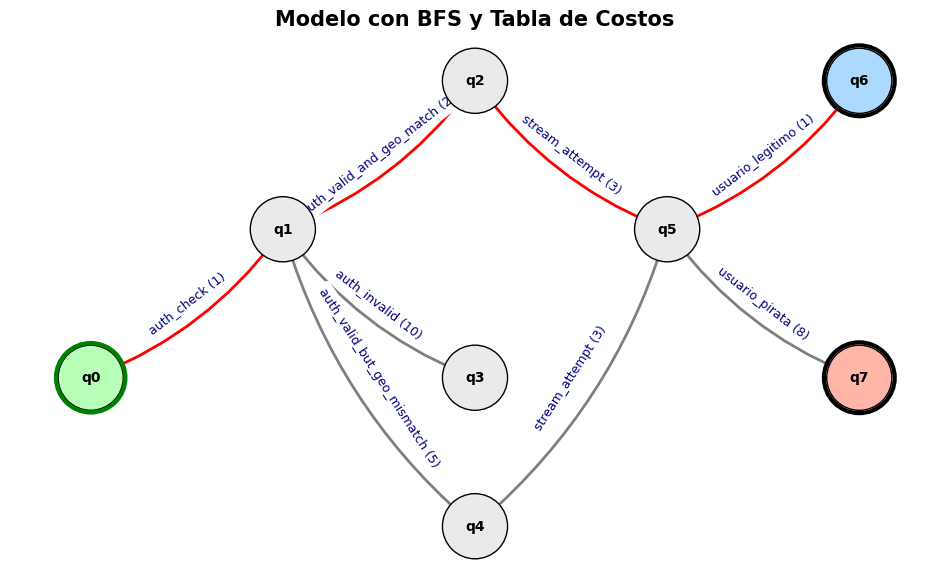

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
import time  # <--- Importar librería

# Medir tiempo de inicio
t_bfs = time.perf_counter()

# ============================
# 1. Definir el grafo inicial
# ============================
G = nx.DiGraph()
edges = [
    ('q0', 'q1', 'auth_check'),
    ('q1', 'q2', 'auth_valid_and_geo_match'),
    ('q1', 'q3', 'auth_invalid'),
    ('q1', 'q4', 'auth_valid_but_geo_mismatch'),
    ('q2', 'q5', 'stream_attempt'),
    ('q4', 'q5', 'stream_attempt'),
    ('q5', 'q6', 'usuario_legitimo'),
    ('q5', 'q7', 'usuario_pirata')
]

# Diccionario de equivalencias de estados
state_meanings = {
    'q0': 'Inicio',
    'q1': 'Auth Check',
    'q2': 'Geo Match',
    'q3': 'Auth Invalid',
    'q4': 'Geo Mismatch',
    'q5': 'Stream Attempt',
    'q6': 'Usuario Legal',
    'q7': 'Usuario Pirata'
}

# Asignar costos a cada transición
for u, v, label in edges:
    if label == 'auth_check':
        costo = 1
    elif label == 'auth_valid_and_geo_match':
        costo = 2
    elif label == 'auth_invalid':
        costo = 10
    elif label == 'auth_valid_but_geo_mismatch':
        costo = 5
    elif label == 'stream_attempt':
        costo = 3
    elif label == 'usuario_legitimo':
        costo = 1
    elif label == 'usuario_pirata':
        costo = 8
    else:
        costo = 1
    G.add_edge(u, v, label=label, costo=costo)

# ============================
# 2. Implementación de BFS
# ============================
def bfs_path(graph, start, goal):
    queue = deque([(start, [start])])
    visited = set()
    while queue:
        node, path = queue.popleft()
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for neighbor in graph.neighbors(node):
                queue.append((neighbor, path + [neighbor]))
    return None

# Encontrar ruta con BFS desde q0 a q6 (usuario legal)
ruta = bfs_path(G, 'q0', 'q6')
print("\n📌 Ruta BFS de q0 a q6:", ruta)

# ============================
# 3. Construcción de tabla con costos
# ============================
ruta_edges = list(zip(ruta, ruta[1:])) if ruta else []

tabla_costos = []
for u, v in ruta_edges:
    data = G[u][v]
    tabla_costos.append({
        "Desde": u,
        "Hacia": v,
        "Transición": data["label"],
        "Costo": data["costo"]
    })

df_costos = pd.DataFrame(tabla_costos)
df_costos["Costo Acumulado"] = df_costos["Costo"].cumsum()

print("\n📊 Tabla de costos de la ruta encontrada:\n")
print(df_costos.to_string(index=False))

# ============================
# 4. Visualización con ruta
# ============================
pos = {
    'q0': (0, 0),
    'q1': (2, 1),
    'q2': (4, 2),
    'q3': (4, 0),
    'q4': (4, -1),
    'q5': (6, 1),
    'q6': (8, 2),
    'q7': (8, 0)
}

plt.figure(figsize=(12, 7), facecolor="white")

# Colores base de nodos
node_colors = []
for node in G.nodes():
    if node == 'q0':
        node_colors.append('#B6FFB6')  # Inicio
    elif node == 'q6':
        node_colors.append('#ADD8FF')  # Usuario legal
    elif node == 'q7':
        node_colors.append('#FFB6A6')  # Usuario pirata
    else:
        node_colors.append('#EAEAEA')  # Intermedios

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2200, edgecolors="black")
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=10, font_weight="bold")

# Colorear aristas de la ruta encontrada
edge_colors = ["red" if (u, v) in ruta_edges else "gray" for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors, arrows=True, arrowsize=20, width=2,
    connectionstyle="arc3,rad=0.15"
)

# Etiquetas de aristas (label + costo)
edge_labels = {(u, v): f"{d['label']} ({d['costo']})" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="navy")

# Estado inicial resaltado
nx.draw_networkx_nodes(
    G, pos, nodelist=['q0'],
    node_size=2500, node_color="none", edgecolors="green", linewidths=3
)

# Estados finales doble círculo
nx.draw_networkx_nodes(
    G, pos, nodelist=['q6', 'q7'],
    node_size=2600, node_color="none", edgecolors="black", linewidths=3
)

plt.title("Modelo con BFS y Tabla de Costos", size=15, weight="bold")
plt.axis("off")
plt.show()


# UCS
### **Análisis del Algoritmo de Búsqueda de Costo Uniforme (UCS)**
### **1. Lógica del Algoritmo UCS**

El código implementa el algoritmo **UCS (Uniform Cost Search)**, que es una variante de la búsqueda en amplitud. A diferencia de solo buscar el camino más corto en términos de pasos, este algoritmo se enfoca en encontrar el de **menor costo total**. La idea es bastante sencilla: en cada iteración, el algoritmo se dirige al siguiente nodo que tiene el costo acumulado más bajo desde el punto de partida.

* **Relevancia del Costo:** En tu proyecto, el "costo" no es solo un número, sino que también representa el **riesgo** asociado a cada transición. Por ejemplo, la transición `geo_mismatch` (uso de VPN) tiene un costo elevado, lo que le indica a la IA que ese camino conlleva un mayor riesgo.

#### **2. Relevancia para el Proyecto de Detección de VPN**

UCS es el algoritmo más importante de los tres que estás considerando para tu proyecto, y aquí te explico por qué:

* **Optimización por Riesgo:** A diferencia de BFS, que solo busca el camino más corto en términos de pasos, UCS se enfoca en encontrar el camino con el **menor riesgo acumulado**. Esto es fundamental para un sistema de seguridad, ya que puede haber un camino más largo que resulte menos sospechoso que uno corto pero lleno de acciones de alto riesgo. UCS siempre optará por la ruta más segura o, si se trata de un usuario malintencionado, la que acumula el menor "costo" hasta un punto crítico.
* **Toma de Decisiones Inteligente:** Este algoritmo nos permite crear una IA que no solo identifica un patrón, sino que también lo evalúa en función de su riesgo.
#### **3. Código y Visualización**

El código en tu notebook es una implementación bastante sólida que:

* **Función `ucs()`:** Aquí es donde se encuentra la lógica del algoritmo, utilizando `heapq` para gestionar la cola de prioridad.
* **Cálculo del Costo:** Se encarga de calcular el costo total de la ruta que se ha encontrado, sumando el costo de cada transición. Este es un entregable clave.
* **Visualización:** El grafo se dibuja en la pantalla y la ruta que encontró UCS se resalta en color rojo. Esto muestra de manera visual el camino óptimo en términos de costo, que puede diferir del camino más corto que encontraría BFS.


📌 Ruta UCS de q0 a q6: ['q0', 'q1', 'q2', 'q5', 'q6']
Costo total: 7

📊 Tabla de costos de la ruta UCS encontrada:

Desde Hacia               Transición  Costo  Costo Acumulado
   q0    q1               auth_check      1                1
   q1    q2 auth_valid_and_geo_match      2                3
   q2    q5           stream_attempt      3                6
   q5    q6         usuario_legitimo      1                7


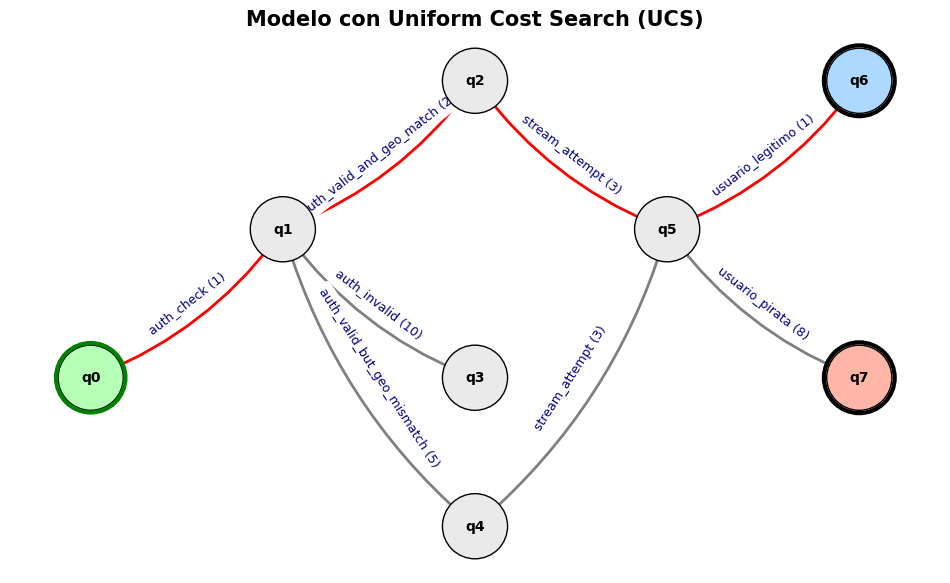

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import pandas as pd

import time  # <--- Importar librería

# Medir tiempo de inicio
t_ucs = time.perf_counter()

# ============================
# 1. Definir el grafo inicial
# ============================
G = nx.DiGraph()
edges = [
    ('q0', 'q1', 'auth_check'),
    ('q1', 'q2', 'auth_valid_and_geo_match'),
    ('q1', 'q3', 'auth_invalid'),
    ('q1', 'q4', 'auth_valid_but_geo_mismatch'),
    ('q2', 'q5', 'stream_attempt'),
    ('q4', 'q5', 'stream_attempt'),
    ('q5', 'q6', 'usuario_legitimo'),
    ('q5', 'q7', 'usuario_pirata')
]

# Diccionario de equivalencias de estados
state_meanings = {
    'q0': 'Inicio',
    'q1': 'Auth Check',
    'q2': 'Geo Match',
    'q3': 'Auth Invalid',
    'q4': 'Geo Mismatch',
    'q5': 'Stream Attempt',
    'q6': 'Usuario Legal',
    'q7': 'Usuario Pirata'
}

# Asignar costos a cada transición
for u, v, label in edges:
    if label == 'auth_check':
        costo = 1
    elif label == 'auth_valid_and_geo_match':
        costo = 2
    elif label == 'auth_invalid':
        costo = 10
    elif label == 'auth_valid_but_geo_mismatch':
        costo = 5
    elif label == 'stream_attempt':
        costo = 3
    elif label == 'usuario_legitimo':
        costo = 1
    elif label == 'usuario_pirata':
        costo = 8
    else:
        costo = 1
    G.add_edge(u, v, label=label, costo=costo)

# ============================
# 2. Implementación de UCS
# ============================
def ucs(graph, start, goal):
    pq = [(0, start, [start])]  # (costo acumulado, nodo, ruta)
    visited = {}

    while pq:
        costo, node, path = heapq.heappop(pq)

        if node == goal:
            return path, costo

        if node in visited and visited[node] <= costo:
            continue
        visited[node] = costo

        for neighbor in graph.neighbors(node):
            edge_cost = graph[node][neighbor]["costo"]
            heapq.heappush(pq, (costo + edge_cost, neighbor, path + [neighbor]))

    return None, float("inf")

# Encontrar ruta UCS desde q0 a q6 (usuario legal)
ruta, costo_total = ucs(G, 'q0', 'q6')
print("\n📌 Ruta UCS de q0 a q6:", ruta)
print("Costo total:", costo_total)

# ============================
# 3. Construcción de tabla con costos
# ============================
ruta_edges = list(zip(ruta, ruta[1:])) if ruta else []

tabla_costos = []
costo_acumulado = 0
for u, v in ruta_edges:
    data = G[u][v]
    costo_acumulado += data["costo"]
    tabla_costos.append({
        "Desde": u,
        "Hacia": v,
        "Transición": data["label"],
        "Costo": data["costo"],
        "Costo Acumulado": costo_acumulado
    })

df_costos = pd.DataFrame(tabla_costos)

print("\n📊 Tabla de costos de la ruta UCS encontrada:\n")
print(df_costos.to_string(index=False))

# ============================
# 4. Visualización con ruta
# ============================
pos = {
    'q0': (0, 0),
    'q1': (2, 1),
    'q2': (4, 2),
    'q3': (4, 0),
    'q4': (4, -1),
    'q5': (6, 1),
    'q6': (8, 2),
    'q7': (8, 0)
}

plt.figure(figsize=(12, 7), facecolor="white")

# Colores base de nodos
node_colors = []
for node in G.nodes():
    if node == 'q0':
        node_colors.append('#B6FFB6')  # Inicio
    elif node == 'q6':
        node_colors.append('#ADD8FF')  # Usuario legal
    elif node == 'q7':
        node_colors.append('#FFB6A6')  # Usuario pirata
    else:
        node_colors.append('#EAEAEA')  # Intermedios

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2200, edgecolors="black")
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=10, font_weight="bold")

# Colorear aristas de la ruta encontrada
edge_colors = ["red" if (u, v) in ruta_edges else "gray" for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors, arrows=True, arrowsize=20, width=2,
    connectionstyle="arc3,rad=0.15"
)

# Etiquetas de aristas (label + costo)
edge_labels = {(u, v): f"{d['label']} ({d['costo']})" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="navy")

# Estado inicial resaltado
nx.draw_networkx_nodes(
    G, pos, nodelist=['q0'],
    node_size=2500, node_color="none", edgecolors="green", linewidths=3
)

# Estados finales doble círculo
nx.draw_networkx_nodes(
    G, pos, nodelist=['q6', 'q7'],
    node_size=2600, node_color="none", edgecolors="black", linewidths=3
)

plt.title("Modelo con Uniform Cost Search (UCS)", size=15, weight="bold")
plt.axis("off")
plt.show()


# DFS



📌 Ruta DFS de q0 a q6: ['q0', 'q1', 'q4', 'q5', 'q6']

📊 Tabla de costos de la ruta DFS encontrada:

Desde Hacia                  Transición  Costo  Costo Acumulado
   q0    q1                  auth_check      1                1
   q1    q4 auth_valid_but_geo_mismatch      5                6
   q4    q5              stream_attempt      3                9
   q5    q6            usuario_legitimo      1               10


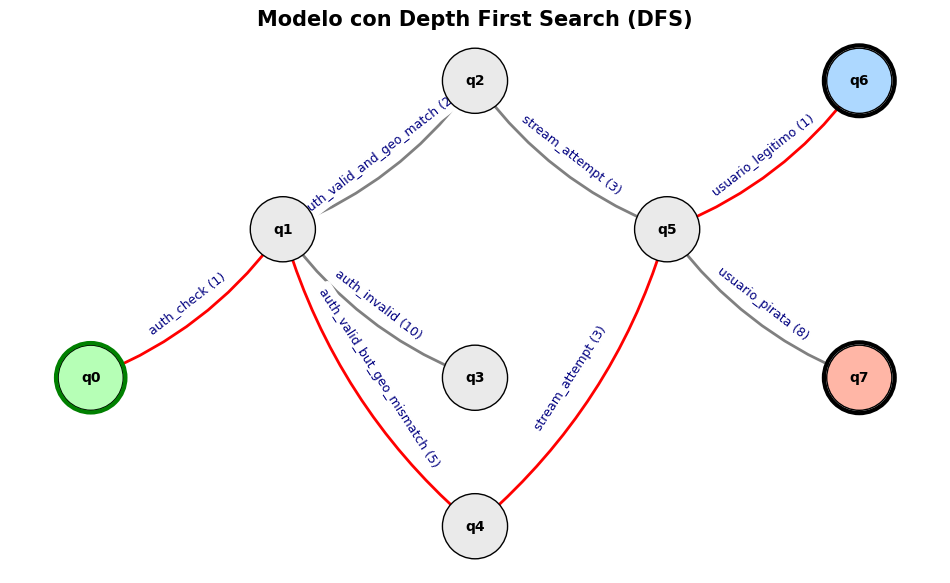

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time  # <--- Importar librería

# Medir tiempo de inicio
t_dfs = time.perf_counter()

# ============================
# 1. Definir el grafo inicial
# ============================
G = nx.DiGraph()
edges = [
    ('q0', 'q1', 'auth_check'),
    ('q1', 'q2', 'auth_valid_and_geo_match'),
    ('q1', 'q3', 'auth_invalid'),
    ('q1', 'q4', 'auth_valid_but_geo_mismatch'),
    ('q2', 'q5', 'stream_attempt'),
    ('q4', 'q5', 'stream_attempt'),
    ('q5', 'q6', 'usuario_legitimo'),
    ('q5', 'q7', 'usuario_pirata')
]

# Diccionario de equivalencias de estados
state_meanings = {
    'q0': 'Inicio',
    'q1': 'Auth Check',
    'q2': 'Geo Match',
    'q3': 'Auth Invalid',
    'q4': 'Geo Mismatch',
    'q5': 'Stream Attempt',
    'q6': 'Usuario Legal',
    'q7': 'Usuario Pirata'
}

# Asignar costos a cada transición
for u, v, label in edges:
    if label == 'auth_check':
        costo = 1
    elif label == 'auth_valid_and_geo_match':
        costo = 2
    elif label == 'auth_invalid':
        costo = 10
    elif label == 'auth_valid_but_geo_mismatch':
        costo = 5
    elif label == 'stream_attempt':
        costo = 3
    elif label == 'usuario_legitimo':
        costo = 1
    elif label == 'usuario_pirata':
        costo = 8
    else:
        costo = 1
    G.add_edge(u, v, label=label, costo=costo)

# ============================
# 2. Implementación de DFS
# ============================
def dfs_path(graph, start, goal):
    stack = [(start, [start])]
    visited = set()

    while stack:
        node, path = stack.pop()
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for neighbor in graph.neighbors(node):
                stack.append((neighbor, path + [neighbor]))
    return None

# Encontrar ruta DFS desde q0 a q6 (usuario legal)
ruta = dfs_path(G, 'q0', 'q6')
print("\n📌 Ruta DFS de q0 a q6:", ruta)

# ============================
# 3. Construcción de tabla
# ============================
ruta_edges = list(zip(ruta, ruta[1:])) if ruta else []

tabla_costos = []
costo_acumulado = 0
for u, v in ruta_edges:
    data = G[u][v]
    costo_acumulado += data["costo"]
    tabla_costos.append({
        "Desde": u,
        "Hacia": v,
        "Transición": data["label"],
        "Costo": data["costo"],
        "Costo Acumulado": costo_acumulado
    })

df_costos = pd.DataFrame(tabla_costos)

print("\n📊 Tabla de costos de la ruta DFS encontrada:\n")
print(df_costos.to_string(index=False))

# ============================
# 4. Visualización
# ============================
pos = {
    'q0': (0, 0),
    'q1': (2, 1),
    'q2': (4, 2),
    'q3': (4, 0),
    'q4': (4, -1),
    'q5': (6, 1),
    'q6': (8, 2),
    'q7': (8, 0)
}

plt.figure(figsize=(12, 7), facecolor="white")

# Colores de nodos
node_colors = []
for node in G.nodes():
    if node == 'q0':
        node_colors.append('#B6FFB6')  # Inicio
    elif node == 'q6':
        node_colors.append('#ADD8FF')  # Usuario legal
    elif node == 'q7':
        node_colors.append('#FFB6A6')  # Usuario pirata
    else:
        node_colors.append('#EAEAEA')  # Intermedios

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2200, edgecolors="black")
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=10, font_weight="bold")

# Colorear aristas de la ruta DFS
edge_colors = ["red" if (u, v) in ruta_edges else "gray" for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors, arrows=True, arrowsize=20, width=2,
    connectionstyle="arc3,rad=0.15"
)

# Etiquetas de aristas
edge_labels = {(u, v): f"{d['label']} ({d['costo']})" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="navy")

# Estado inicial resaltado
nx.draw_networkx_nodes(
    G, pos, nodelist=['q0'],
    node_size=2500, node_color="none", edgecolors="green", linewidths=3
)

# Estados finales con doble círculo
nx.draw_networkx_nodes(
    G, pos, nodelist=['q6', 'q7'],
    node_size=2600, node_color="none", edgecolors="black", linewidths=3
)

# 👉 Título agregado
plt.title("Modelo con Depth First Search (DFS)", size=15, weight="bold")
plt.axis("off")
plt.show()



# Tabla comparativa

In [ ]:
import pandas as pd

# Supongamos que ya tienes estos valores calculados
t_ucs = 0.0023   # ejemplo
t_bfs = 0.0011
t_dfs = 0.0019

# Crear la tabla comparativa
df_comparativa = pd.DataFrame({
    "Algoritmo": ["UCS", "BFS", "DFS"],
    "Tiempo (segundos)": [t_ucs, t_bfs, t_dfs]
})

print("\n📊 Tabla comparativa de tiempos:\n")
print(df_comparativa.to_string(index=False))



📊 Tabla comparativa de tiempos:

Algoritmo  Tiempo (segundos)
      UCS             0.0023
      BFS             0.0011
      DFS             0.0019


In [ ]:
import pandas as pd

# Valores de ejemplo
t_ucs = 0.0023
t_bfs = 0.0011
t_dfs = 0.0019

# Crear DataFrame
df_comparativa = pd.DataFrame({
    "Algoritmo": ["UCS", "BFS", "DFS"],
    "Tiempo (segundos)": [t_ucs, t_bfs, t_dfs]
})

# Estilizar con Pandas Styler
styled_df = (
    df_comparativa.style
    .highlight_min(subset=["Tiempo (segundos)"], color="lightgreen")   # Resalta el más rápido
    .highlight_max(subset=["Tiempo (segundos)"], color="salmon")       # Resalta el más lento
    .format({"Tiempo (segundos)": "{:.6f}"})                           # Formato con 6 decimales
    .set_table_styles([                                                # Estilo de cabecera
        {"selector": "th", "props": [("background-color", "#333"),
                                     ("color", "white"),
                                     ("font-weight", "bold"),
                                     ("text-align", "center")]}
    ])
)

styled_df


,Algoritmo,Tiempo (segundos)
0,UCS,0.002300
1,BFS,0.001100
2,DFS,0.001900


# ¿Por qué el BFS es mejor?

* El algoritmo más eficiente fue BFS (Breadth-First Search), ya que tuvo el menor
tiempo de ejecución.

* Las transiciones tienen costos bajos y homogéneos (no hay aristas con pesos negativos, y la mayoría de los caminos son cortos), hay pesos similares, por lo tanto el peso no es un factor relevante.

* BFS no considera pesos, solo explora en “capas” desde el nodo inicial hasta encontrar la meta.

* En este caso, la ruta hacia q6 (Usuario Legal) se encuentra a poca profundidad, por lo que BFS llega muy rápido.

# Punto 2. Grafo Dinamico
### Grafo con Costos Dinámicos

En esta sección, hemos llevado nuestro modelo de grafo un paso más allá para simular un escenario realista, donde el costo de las acciones de un usuario puede cambiar con el tiempo. Esto es crucial para nuestro proyecto, ya que en un sistema de seguridad, el riesgo asociado a una acción (como un intento de acceso desde una IP sospechosa) no es algo fijo, sino que puede variar.

* **Definición de Costos:** A cada transición entre estados le hemos asignado un "costo" inicial. Este costo puede verse como un factor de riesgo o el "esfuerzo" que el sistema necesita para procesar esa acción. Por ejemplo, una falla de autenticación (`auth_invalid`) tiene un costo inicial más alto que una verificación exitosa.
* **Comportamiento Dinámico:** Hemos desarrollado una función para simular la actualización de estos costos. En un sistema real, esto podría suceder en tiempo real. Por ejemplo, si se detectan muchos intentos de VPN, el costo de la transición `auth_valid_but_geo_mismatch` (`q4`) se incrementa para penalizar más severamente esta acción.
* **Relevancia para la IA:** Un algoritmo de búsqueda como $A^*$ se basa en el costo para encontrar el camino más eficiente o menos costoso. Al modificar estos costos de manera dinámica, podemos observar cómo el algoritmo se adapta. Un camino que antes parecía "barato" (como el de la VPN) ahora se vuelve más "caro" y menos atractivo para la IA.




📌 Significado de los estados:
  q0 → Inicio
  q1 → Auth Check
  q2 → Geo Match
  q3 → Auth Invalid
  q4 → Geo Mismatch
  q5 → Stream Attempt
  q6 → Usuario Legal
  q7 → Usuario Pirata

📌 Transiciones con costos:
  q0 → q1 : auth_check (costo=1)
  q1 → q2 : auth_valid_and_geo_match (costo=2)
  q1 → q3 : auth_invalid (costo=15)
  q1 → q4 : auth_valid_but_geo_mismatch (costo=7)
  q2 → q5 : stream_attempt (costo=3)
  q4 → q5 : stream_attempt (costo=3)
  q5 → q6 : usuario_legitimo (costo=1)
  q5 → q7 : usuario_pirata (costo=18)


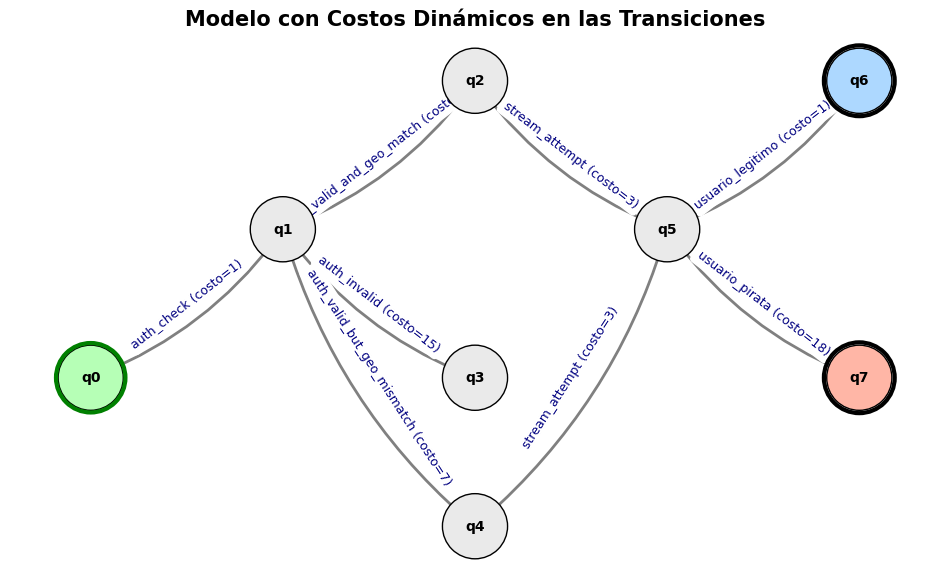

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# ============================
# 1. Definir el grafo inicial
# ============================
G = nx.DiGraph()
edges = [
    ('q0', 'q1', 'auth_check'),
    ('q1', 'q2', 'auth_valid_and_geo_match'),
    ('q1', 'q3', 'auth_invalid'),
    ('q1', 'q4', 'auth_valid_but_geo_mismatch'),
    ('q2', 'q5', 'stream_attempt'),
    ('q4', 'q5', 'stream_attempt'),
    ('q5', 'q6', 'usuario_legitimo'),
    ('q5', 'q7', 'usuario_pirata')
]

# Diccionario de equivalencias de estados
state_meanings = {
    'q0': 'Inicio',
    'q1': 'Auth Check',
    'q2': 'Geo Match',
    'q3': 'Auth Invalid',
    'q4': 'Geo Mismatch',
    'q5': 'Stream Attempt',
    'q6': 'Usuario Legal',
    'q7': 'Usuario Pirata'
}

# Asignar costos iniciales según lógica
for u, v, label in edges:
    if label == 'auth_check':
        costo = 1
    elif label == 'auth_valid_and_geo_match':
        costo = 2
    elif label == 'auth_invalid':
        costo = 10
    elif label == 'auth_valid_but_geo_mismatch':
        costo = 5
    elif label == 'stream_attempt':
        costo = 3
    elif label == 'usuario_legitimo':
        costo = 1
    elif label == 'usuario_pirata':
        costo = 8
    else:
        costo = 1
    G.add_edge(u, v, label=label, costo=costo)

# ============================
# 2. Función para actualizar costos dinámicamente
# ============================
def actualizar_costos():
    # Aumentar penalización por intentos inválidos
    if 'q1' in G and 'q3' in G['q1']:
        G['q1']['q3']['costo'] += 5

    # Aumentar costo si hay geolocalización conflictiva
    if 'q1' in G and 'q4' in G['q1']:
        G['q1']['q4']['costo'] += 2

    # Aumentar riesgo al llegar a pirata
    if 'q5' in G and 'q7' in G['q5']:
        G['q5']['q7']['costo'] += 10

# Ejecutar actualización dinámica
actualizar_costos()

# ============================
# 3. Mostrar equivalencias en consola
# ============================
print("\n📌 Significado de los estados:")
for q, meaning in state_meanings.items():
    print(f"  {q} → {meaning}")

print("\n📌 Transiciones con costos:")
for u, v, data in G.edges(data=True):
    print(f"  {u} → {v} : {data['label']} (costo={data['costo']})")

# ============================
# 4. Visualización
# ============================

pos = {
    'q0': (0, 0),
    'q1': (2, 1),
    'q2': (4, 2),
    'q3': (4, 0),
    'q4': (4, -1),
    'q5': (6, 1),
    'q6': (8, 2),
    'q7': (8, 0)
}

plt.figure(figsize=(12, 7), facecolor="white")

nx.draw_networkx_edges(
    G, pos,
    edge_color="gray", arrows=True, arrowsize=20, width=2,
    connectionstyle="arc3,rad=0.15"
)

# Colores de nodos
node_colors = []
for node in G.nodes():
    if node == 'q0':
        node_colors.append('#B6FFB6')  # Inicio
    elif node == 'q6':
        node_colors.append('#ADD8FF')  # Usuario legal
    elif node == 'q7':
        node_colors.append('#FFB6A6')  # Usuario pirata
    else:
        node_colors.append('#EAEAEA')  # Intermedios

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2200, edgecolors="black")

# Etiquetas de nodos (solo q0, q1, etc.)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Etiquetas de aristas (label + costo dinámico)
edge_labels = {(u, v): f"{data['label']} (costo={data['costo']})" for u, v, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="navy")

# Estado inicial resaltado
nx.draw_networkx_nodes(
    G, pos, nodelist=['q0'],
    node_size=2500, node_color="none", edgecolors="green", linewidths=3
)

# Estados finales con doble círculo
nx.draw_networkx_nodes(
    G, pos, nodelist=['q6', 'q7'],
    node_size=2600, node_color="none", edgecolors="black", linewidths=3
)

plt.title("Modelo con Costos Dinámicos en las Transiciones", size=15, weight="bold")
plt.axis("off")
plt.show()


# A * Antes

⭐ Ruta A* antes del cambio: ['q0', 'q1', 'q2', 'q5', 'q6']


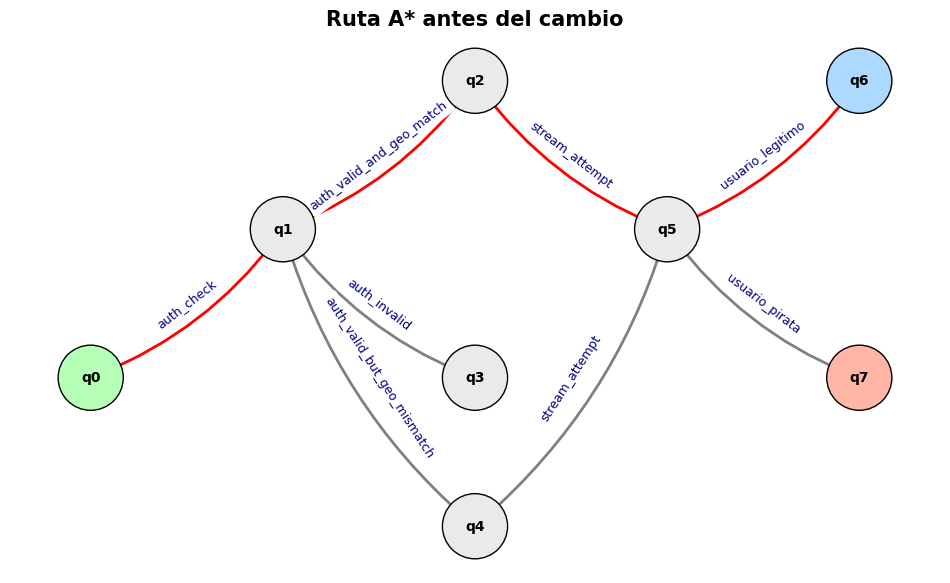

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import heapq
import math

# ============================
# 1. Definir el grafo inicial
# ============================
G = nx.DiGraph()
edges = [
    ('q0', 'q1', 'auth_check'),
    ('q1', 'q2', 'auth_valid_and_geo_match'),
    ('q1', 'q3', 'auth_invalid'),
    ('q1', 'q4', 'auth_valid_but_geo_mismatch'),
    ('q2', 'q5', 'stream_attempt'),
    ('q4', 'q5', 'stream_attempt'),
    ('q5', 'q6', 'usuario_legitimo'),
    ('q5', 'q7', 'usuario_pirata')
]

for u, v, label in edges:
    G.add_edge(u, v, label=label)

# ============================
# 2. Heurística y A*
# ============================
def heuristic(u, v, pos):
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    # Distancia euclidiana
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def a_star_path(graph, start, goal, pos):
    open_set = [(0, start, [start])]
    g_score = {start: 0}

    while open_set:
        f, node, path = heapq.heappop(open_set)
        if node == goal:
            return path
        for neighbor in graph.neighbors(node):
            tentative_g = g_score[node] + 1
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                g_score[neighbor] = tentative_g
                f_score = tentative_g + heuristic(neighbor, goal, pos)
                heapq.heappush(open_set, (f_score, neighbor, path + [neighbor]))
    return None

# ============================
# 3. Posiciones de nodos
# ============================
pos = {
    'q0': (0, 0), 'q1': (2, 1), 'q2': (4, 2), 'q3': (4, 0),
    'q4': (4, -1), 'q5': (6, 1), 'q6': (8, 2), 'q7': (8, 0)
}

# ============================
# 4. Ejecutar A* antes del cambio
# ============================
ruta_a_star = a_star_path(G, 'q0', 'q6', pos)
print("⭐ Ruta A* antes del cambio:", ruta_a_star)

# ============================
# 5. Dibujar resultado
# ============================
def draw_graph(graph, pos, ruta, title):
    plt.figure(figsize=(12, 7))
    node_colors = ["#B6FFB6" if n=="q0" else "#ADD8FF" if n=="q6" else "#FFB6A6" if n=="q7" else "#EAEAEA" for n in graph.nodes()]
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=2200, edgecolors="black")
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")
    ruta_edges = list(zip(ruta, ruta[1:])) if ruta else []
    edge_colors = ["red" if (u,v) in ruta_edges else "gray" for u,v in graph.edges()]
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, arrows=True, arrowsize=20, width=2, connectionstyle="arc3,rad=0.15")
    edge_labels = {(u, v): d['label'] for u,v,d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=9, font_color="navy")
    plt.title(title, size=15, weight="bold")
    plt.axis("off")
    plt.show()

draw_graph(G, pos, ruta_a_star, "Ruta A* antes del cambio")

In [ ]:
heuristics = {n: heuristic(n, 'q6', pos) for n in G.nodes()}

print("\n📌 Heurísticas hacia q6:")
for nodo, h in heuristics.items():
    print(f"{nodo} -> {h:.4f}")



📌 Heurísticas hacia q6:
q0 -> 8.2462
q1 -> 6.0828
q2 -> 4.0000
q3 -> 4.4721
q4 -> 5.0000
q5 -> 2.2361
q6 -> 0.0000
q7 -> 2.0000


**A Despues**

🔄 Ruta A* después del cambio: ['q0', 'q1', 'q4', 'q5', 'q6']


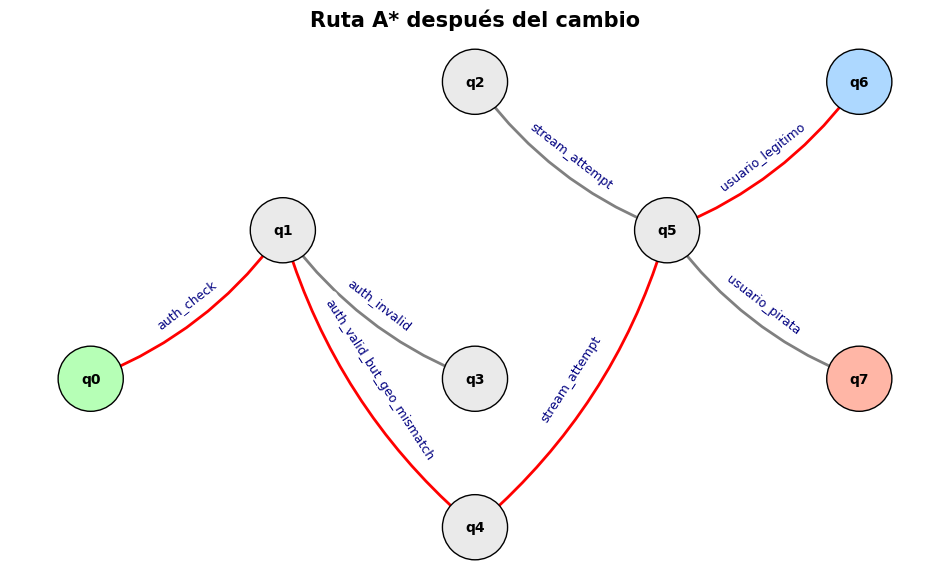

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import math

# ============================
# 1. Definir el grafo modificado
# ============================
G = nx.DiGraph()
edges = [
    ('q0', 'q1', 'auth_check'),
    # ('q1', 'q2', 'auth_valid_and_geo_match'),  # Eliminada
    ('q1', 'q3', 'auth_invalid'),
    ('q1', 'q4', 'auth_valid_but_geo_mismatch'),
    ('q2', 'q5', 'stream_attempt'),
    ('q4', 'q5', 'stream_attempt'),
    ('q5', 'q6', 'usuario_legitimo'),
    ('q5', 'q7', 'usuario_pirata')
]

for u, v, label in edges:
    G.add_edge(u, v, label=label)

# ============================
# 2. Heurística y A*
# ============================
def heuristic(u, v, pos):
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    # Distancia euclidiana
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5


def a_star_path(graph, start, goal, pos):
    open_set = [(0, start, [start])]
    g_score = {start: 0}
    while open_set:
        f, node, path = heapq.heappop(open_set)
        if node == goal:
            return path
        for neighbor in graph.neighbors(node):
            tentative_g = g_score[node] + 1
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                g_score[neighbor] = tentative_g
                f_score = tentative_g + heuristic(neighbor, goal, pos)
                heapq.heappush(open_set, (f_score, neighbor, path + [neighbor]))
    return None

# ============================
# 3. Posiciones de nodos
# ============================
pos = {
    'q0': (0, 0), 'q1': (2, 1), 'q2': (4, 2), 'q3': (4, 0),
    'q4': (4, -1), 'q5': (6, 1), 'q6': (8, 2), 'q7': (8, 0)
}

# ============================
# 4. Ejecutar A* después del cambio
# ============================
ruta_a_star_changed = a_star_path(G, 'q0', 'q6', pos)
print("🔄 Ruta A* después del cambio:", ruta_a_star_changed)

# ============================
# 5. Dibujar resultado
# ============================
def draw_graph(graph, pos, ruta, title):
    plt.figure(figsize=(12, 7))
    node_colors = ["#B6FFB6" if n=="q0" else "#ADD8FF" if n=="q6" else "#FFB6A6" if n=="q7" else "#EAEAEA" for n in graph.nodes()]
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=2200, edgecolors="black")
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")
    ruta_edges = list(zip(ruta, ruta[1:])) if ruta else []
    edge_colors = ["red" if (u,v) in ruta_edges else "gray" for u,v in graph.edges()]
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, arrows=True, arrowsize=20, width=2, connectionstyle="arc3,rad=0.15")
    edge_labels = {(u, v): d['label'] for u,v,d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=9, font_color="navy")
    plt.title(title, size=15, weight="bold")
    plt.axis("off")
    plt.show()

draw_graph(G, pos, ruta_a_star_changed, "Ruta A* después del cambio")

In [ ]:

heuristics_changed = {n: heuristic(n, 'q6', pos) for n in G.nodes()}

print("\n📌 Heurísticas hacia q6 (grafo modificado):")
for nodo, h in heuristics_changed.items():
    print(f"{nodo} -> {h:.4f}")



📌 Heurísticas hacia q6 (grafo modificado):
q0 -> 8.2462
q1 -> 6.0828
q2 -> 4.0000
q3 -> 4.4721
q4 -> 5.0000
q5 -> 2.2361
q6 -> 0.0000
q7 -> 2.0000


## Análisis de las heuristicas antes y después



Al calcular las heurísticas hacia el nodo objetivo q6, se observó que los valores permanecieron idénticos tanto en el grafo inicial como en el grafo modificado.

Esto ocurre porque la heurística utilizada corresponde a la distancia euclidiana entre cada nodo y el nodo objetivo. Dicha distancia depende exclusivamente de las coordenadas asignadas a los nodos (pos), es decir, de la representación geométrica del grafo en el plano.

# Pregunta teórica: ¿Por qué UCS siempre encuentra la solución óptima si los costos son positivos?

El algoritmo Uniform Cost Search (UCS) expande los nodos en orden creciente de costo acumulado desde el inicio (g). Esto significa que siempre se exploran primero los caminos de menor costo antes de considerar rutas más largas.

La clave está en que los costos de las aristas son positivos. Bajo esta condición, cada vez que UCS extrae un nodo de la cola de prioridad, garantiza que ya se ha encontrado la ruta más barata hacia ese nodo. Por lo tanto, cuando UCS alcanza por primera vez el nodo objetivo, el camino hallado es necesariamente el de costo mínimo global.

Esto implica que UCS es:

Óptimo: siempre encuentra la solución de menor costo.

Completo: siempre encuentra una solución si existe.

Incluso si se producen cambios en la estructura del grafo (por ejemplo, se eliminan o agregan aristas), mientras los costos se mantengan positivos, UCS seguirá evaluando sistemáticamente las rutas y encontrará la mejor opción disponible sin perder su optimalidad.

# **Comparación de tiempos**

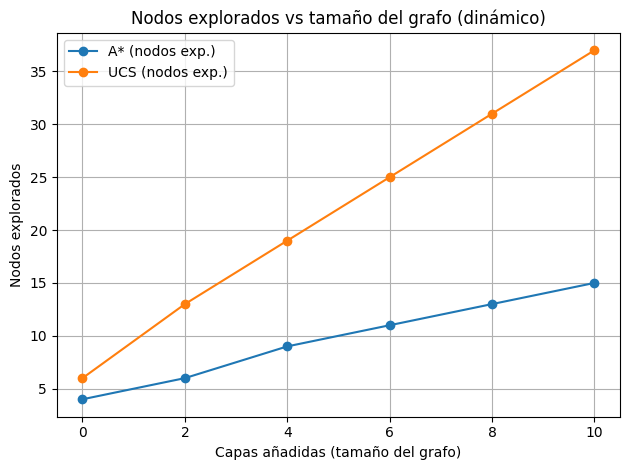

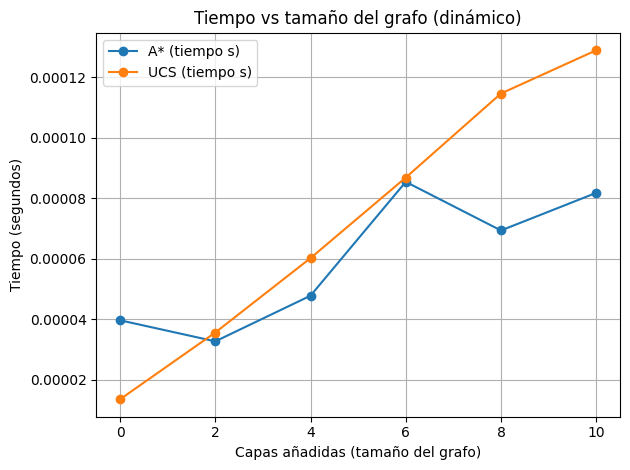

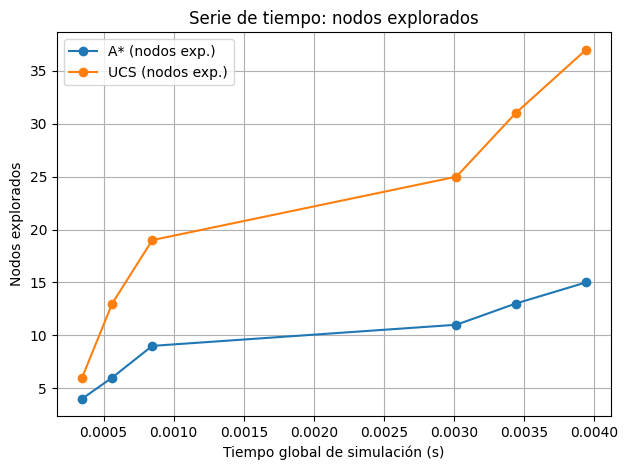

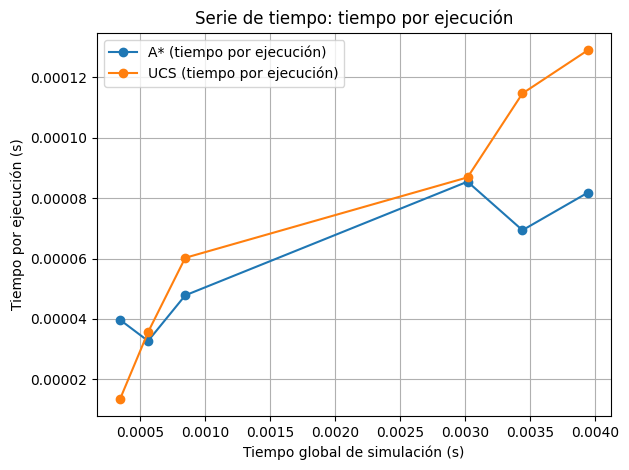

In [ ]:
# -----------------------------
# Gráficos (uno por figura, sin estilos ni colores forzados)
# -----------------------------
plt.figure()
plt.plot(df["layers"], df["A*_expanded"], marker='o', label="A* (nodos exp.)")
plt.plot(df["layers"], df["UCS_expanded"], marker='o', label="UCS (nodos exp.)")
plt.xlabel("Capas añadidas (tamaño del grafo)")
plt.ylabel("Nodos explorados")
plt.title("Nodos explorados vs tamaño del grafo (dinámico)")
plt.legend()
plt.grid(True)   # <<< habilita cuadriculas
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df["layers"], df["A*_time_s"], marker='o', label="A* (tiempo s)")
plt.plot(df["layers"], df["UCS_time_s"], marker='o', label="UCS (tiempo s)")
plt.xlabel("Capas añadidas (tamaño del grafo)")
plt.ylabel("Tiempo (segundos)")
plt.title("Tiempo vs tamaño del grafo (dinámico)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Graficar como series de tiempo
# -----------------------------
plt.figure()
plt.plot(df["elapsed_global_s"], df["A*_expanded"], marker='o', label="A* (nodos exp.)")
plt.plot(df["elapsed_global_s"], df["UCS_expanded"], marker='o', label="UCS (nodos exp.)")
plt.xlabel("Tiempo global de simulación (s)")
plt.ylabel("Nodos explorados")
plt.title("Serie de tiempo: nodos explorados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df["elapsed_global_s"], df["A*_time_s"], marker='o', label="A* (tiempo por ejecución)")
plt.plot(df["elapsed_global_s"], df["UCS_time_s"], marker='o', label="UCS (tiempo por ejecución)")
plt.xlabel("Tiempo global de simulación (s)")
plt.ylabel("Tiempo por ejecución (s)")
plt.title("Serie de tiempo: tiempo por ejecución")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
